In [19]:
#from hapi import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
from scipy.ndimage import uniform_filter1d

In [20]:
def read_data(file_path):
    data = np.loadtxt(file_path)
    x = data[:, 0]
    y = data[:, 1]
    return x, y

In [21]:
def read_dataX(file_path):
    data = np.loadtxt(file_path)
    x = data[:, 0]
    return x

In [22]:
def read_dataY(file_path):
    data = np.loadtxt(file_path)
    y = data[:, 1]
    return y

1. Вычисление полиномиального приближения третьей степени для того, чтобы наилучшим образом описать базовую линию исходного сигнала

In [23]:
def polynomial_fit(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    return polynomial

def remove_outliers_iterative(x, y, degree, threshold=3.0, max_iter=5):
    for _ in range(max_iter):
        polynomial = polynomial_fit(x, y, degree)
        residuals = np.abs(y - polynomial(x))  # Отклонения от модели
        std_dev = np.std(residuals)  # Стандартное отклонение остатков
        mask = residuals <= threshold * std_dev  # Оставляем только данные, удовлетворяющие порогу
        if mask.sum() == len(x):  # Если выбросов нет, завершаем
            break
        x, y = x[mask], y[mask]  # Удаляем выбросы
    return x, y, polynomial

def plot_polynom(x, y, polynomial, title="Полиномиальное приближение", linewidth=3, scatter_size=10):
    plt.figure(figsize=(20, 10))

    plt.scatter(x, y, color='blue', label='Данные', s=scatter_size)
    x_fit = np.linspace(min(x), max(x), 1000)
    y_fit = polynomial(x_fit)  # Вычисляем значения полинома
    plt.plot(x_fit, y_fit, color='green', label='Полиномиальное приближение', linewidth=linewidth)
    plt.xlabel('Point number')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(title)


    plt.axvline(x=min(x), color='red', linestyle='-', label='Начало аппроксимации')
    plt.axvline(x=max(x), color='red', linestyle='-', label='Конец аппроксимации')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

    plt.show()

In [24]:
def main(file_path, degree, threshold=2.0):
    
    x, y = read_data(file_path)

    x_filtered, y_filtered, polynomial = remove_outliers_iterative(x, y, degree, threshold)

    plot_polynom(x, y, polynomial, title="Полиномиальное приближение")

    print('Полученный полином',degree, 'степени:')
    print(polynomial)

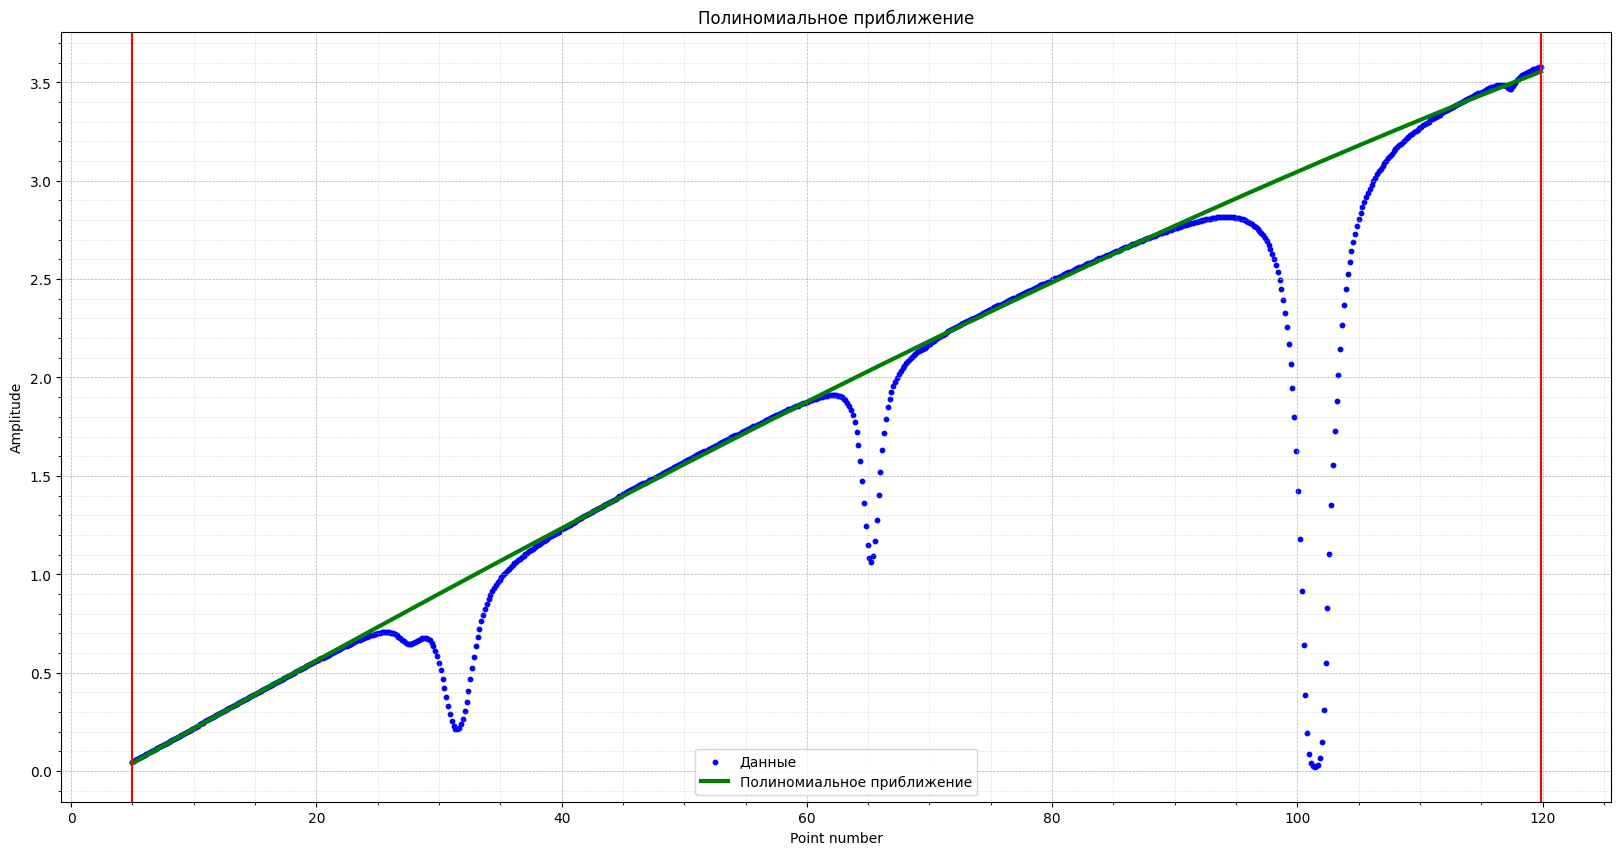

Полученный полином 3 степени:
            3            2
-1.481e-07 x - 1.92e-05 x + 0.03521 x - 0.1351


In [25]:
if __name__ == "__main__":
    file_path = '/Users/dandr/Desktop/Спектроскопия/вода/7180-7183.txt'
    degree = 3  # Степень полинома
    threshold = 2.0
    main(file_path, degree, threshold)


2. Нормировка исходного сигнала на полученное полиномиальное приближение базовой линии.
    Физический смысл промежуточного результата: получение функции пропускания смеси (в данном случае водяного пара).

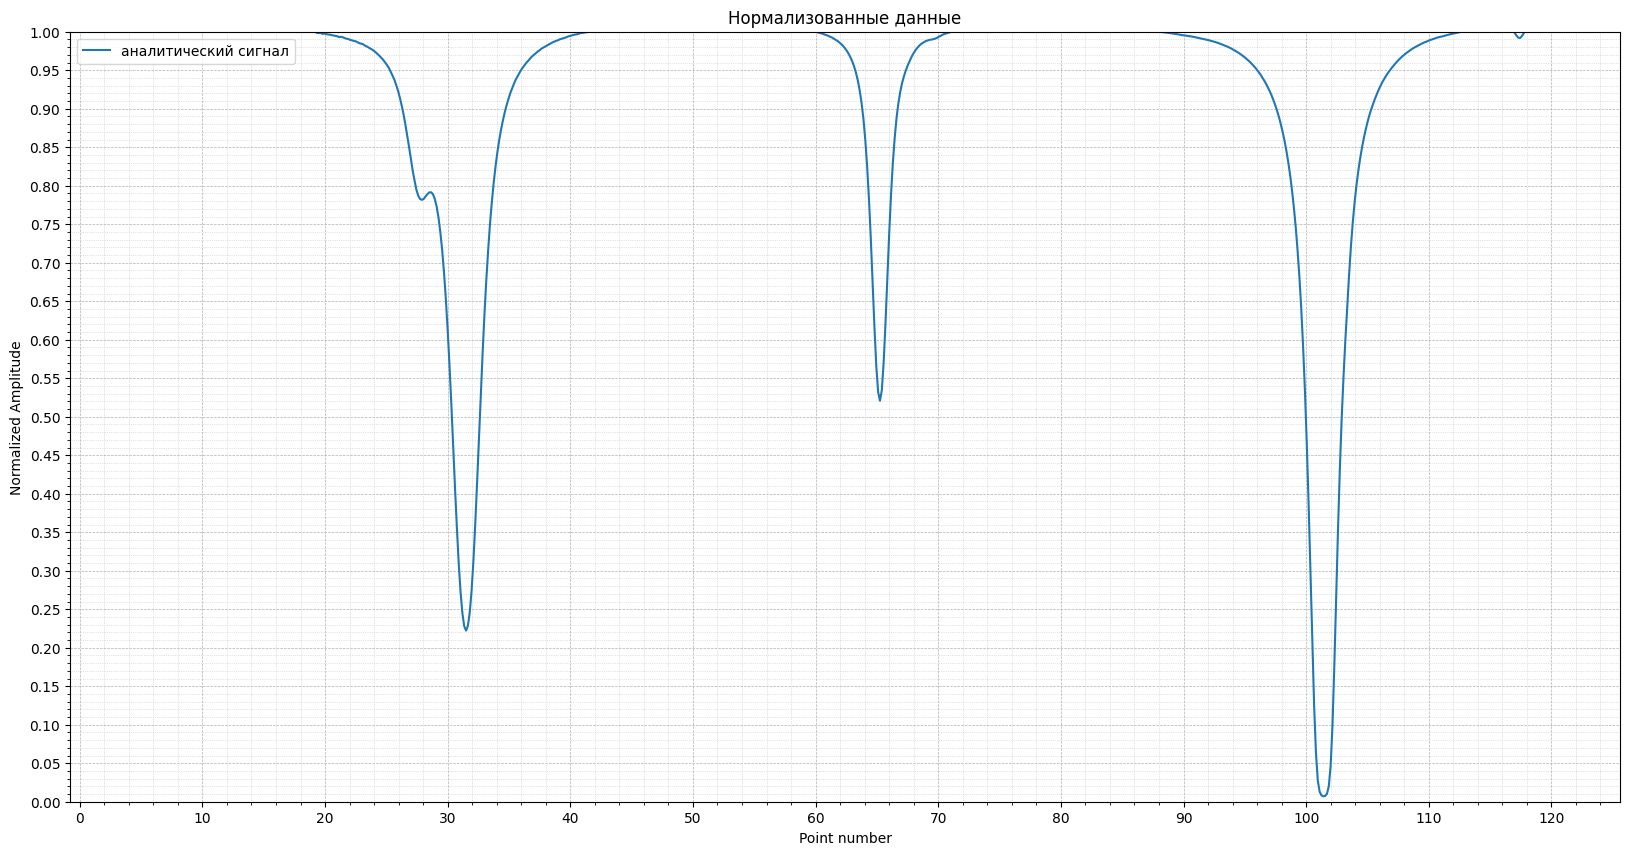

767

In [26]:
# Коэффициенты
a, b, c, d = -1.481e-07, -1.92e-05, 0.03521, -0.1351

# Чтение данных
file_path = '/Users/dandr/desktop/Спектроскопия/вода/7180-7183.txt'
x_D = read_dataX(file_path)
y_D = read_dataY(file_path)

denominator = a * x_D**3 + b * x_D**2 + c * x_D + d   
y_D = y_D / denominator

plt.figure(figsize=(20, 10))
plt.plot(x_D, y_D, label = 'аналитический сигнал')
plt.ylim(0, 1)
plt.title('Нормализованные данные')
plt.xlabel('Point number')
plt.ylabel('Normalized Amplitude')
plt.legend()

plt.locator_params(axis='x', nbins=15)
plt.locator_params(axis='y', nbins=20)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.show()
len(x_D)

3. Линеаризация излучения, проходящего через резонатор Фабри-Перо

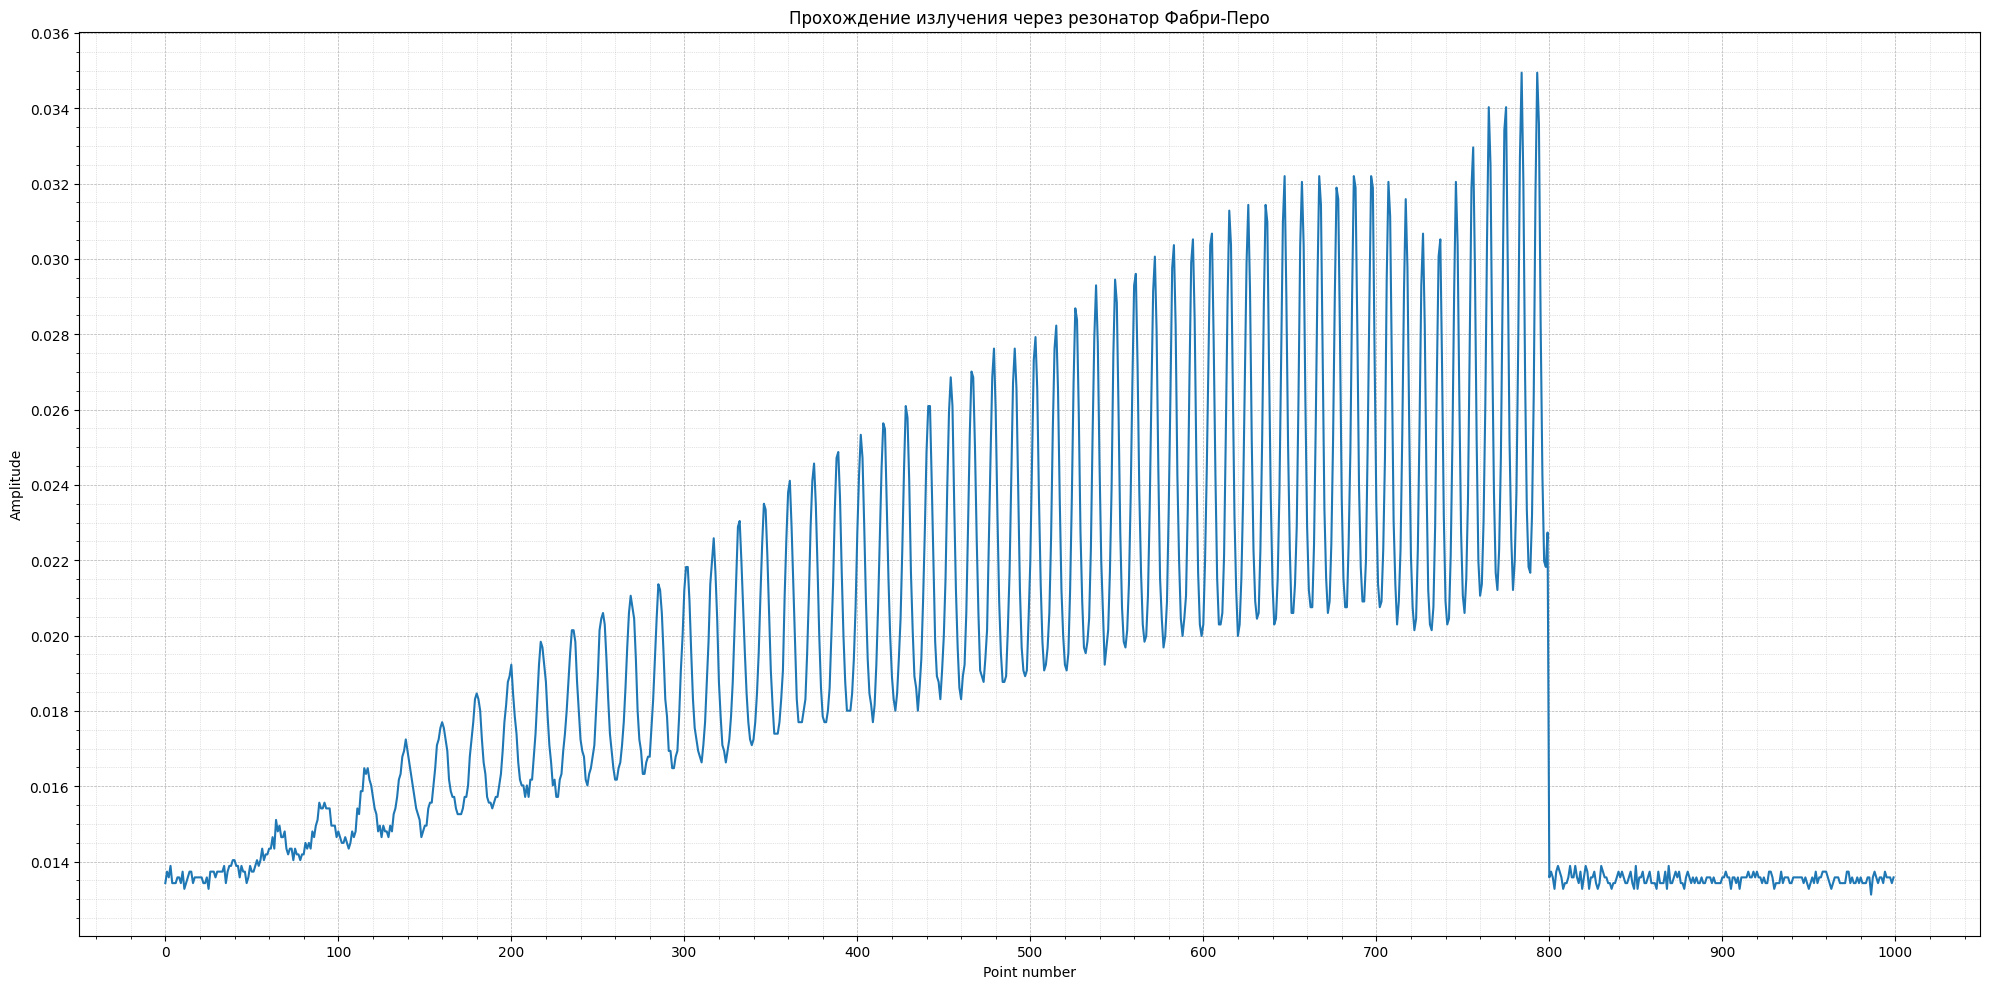

In [27]:
plt.figure(figsize =(20,10))
x_F, y_F = read_data('/Users/dandr/Desktop/Спектроскопия/вода/1.txt')
plt.plot(x_F, y_F)

plt.title('Прохождение излучения через резонатор Фабри-Перо')
plt.xlabel('Point number')
plt.ylabel('Amplitude')


plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.locator_params(axis='x', nbins=20) 
plt.locator_params(axis='y', nbins=20)

plt.tight_layout()
plt.show()

In [28]:
def normalize_data(y):
    return (y - np.min(y)) / (np.max(y) - np.min(y))

#функция сглаживания данных сигнала
def smooth_data(y, window_size=10):
    return uniform_filter1d(y, size=window_size)

#нахождение диапазона сглаженных данных
def find_valid_range(y, threshold=0.1):
    smoothed_y = smooth_data(y)
    mean_y = np.mean(smoothed_y)
    std_y = np.std(smoothed_y)
    lower_bound = mean_y - threshold * std_y
    upper_bound = mean_y + threshold * std_y
    valid_indices = np.where((smoothed_y >= lower_bound) & (smoothed_y <= upper_bound))[0]
    return valid_indices[0], valid_indices[-1]

In [29]:
def find_peaks_and_valleys(y):
    """Нахождение индексов пиков и долин."""
    peaks, _ = find_peaks(y)
    valleys, _ = find_peaks(-y)
    return peaks, valleys

def save_to_file(file_path, max_values, min_values):
    """Сохранение данных в файл."""
    with open(file_path, 'w') as f:
        f.write("Max values:\n")
        np.savetxt(f, max_values, fmt='%f')
        f.write("\nMin values:\n")
        np.savetxt(f, min_values, fmt='%f')

In [30]:
def plot_resonator(x, y, title="Прохождение излучения через резонатор Фабри-Перо"):
    plt.figure(figsize=(20, 10))

    plt.plot(x, y, color='green')
    plt.xlabel('Point number')
    plt.ylabel('Amplitude')
    plt.title(title)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

    plt.locator_params(axis='x', nbins=20)
    plt.locator_params(axis='y', nbins=20)

    plt.show()

In [61]:
def main(file_path, FSR=0.05):

    x, y = read_data(file_path)
    y_normalized = normalize_data(y)

    
    start_idx, end_idx = find_valid_range(y_normalized)
    x_cleaned = x[start_idx:end_idx]
    y_cleaned = y_normalized[start_idx:end_idx]

    # Нахождение пиков
    peaks, valleys = find_peaks_and_valleys(y_cleaned)

    # Сохранение координат пиков
    peaks_x = x_cleaned[peaks]
    peaks_y = y_cleaned[peaks]
    valleys_x = x_cleaned[valleys]
    valleys_y = y_cleaned[valleys]

    
    plt.figure(figsize=(20, 10))
    plt.plot(x_cleaned, y_cleaned, color='green', label = 'нормировка излучения, проходящего через резонатор Фабри-Перо')
    plt.plot(peaks_x, peaks_y,'x', color='red')
    plt.plot(valleys_x, valleys_y, 'x',color='blue')
    plt.xlabel('Point number')
    plt.ylabel('Normalized amplitude')
    plt.title('Определение положения пиков в сигнале, проходящем через резонатор Фабри-Перо')
    plt.legend()
   
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
 
    plt.show()

    combined_x = np.sort(np.concatenate([peaks_x, valleys_x]))
    combined_y = np.concatenate([peaks_y, valleys_y])

    
    try:
        grid_test_combined = [-i * (FSR / 2) for i in range(len(combined_x))]
        interpolated_values = np.interp(x_cleaned, combined_x, grid_test_combined)

        
        plt.figure(figsize=(20, 10))
        plt.plot(x_cleaned, interpolated_values, label='интерполированные значения', color='purple')
        plt.scatter(combined_x, grid_test_combined, color='green', label='max и min по Фабри-Перо')
        plt.xlabel('Point number')
        plt.ylabel('Wavenumber, cm-1')
        plt.title('Линеаризация')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
        plt.show()

    except ValueError as e:
        print(f"Ошибка интерполяции: {e}")

    
    max_values = y_cleaned[peaks]
    min_values = y_cleaned[valleys]

    
    output_file_path = 'peaks_and_valleys.txt'
    save_to_file(output_file_path, max_values, min_values)
    
    
    
    normalized_data_file_path = 'normalized_data.txt'
    np.savetxt(normalized_data_file_path, np.column_stack((x_cleaned, y_cleaned)), fmt='%f', header='Point number\tAmplitude')

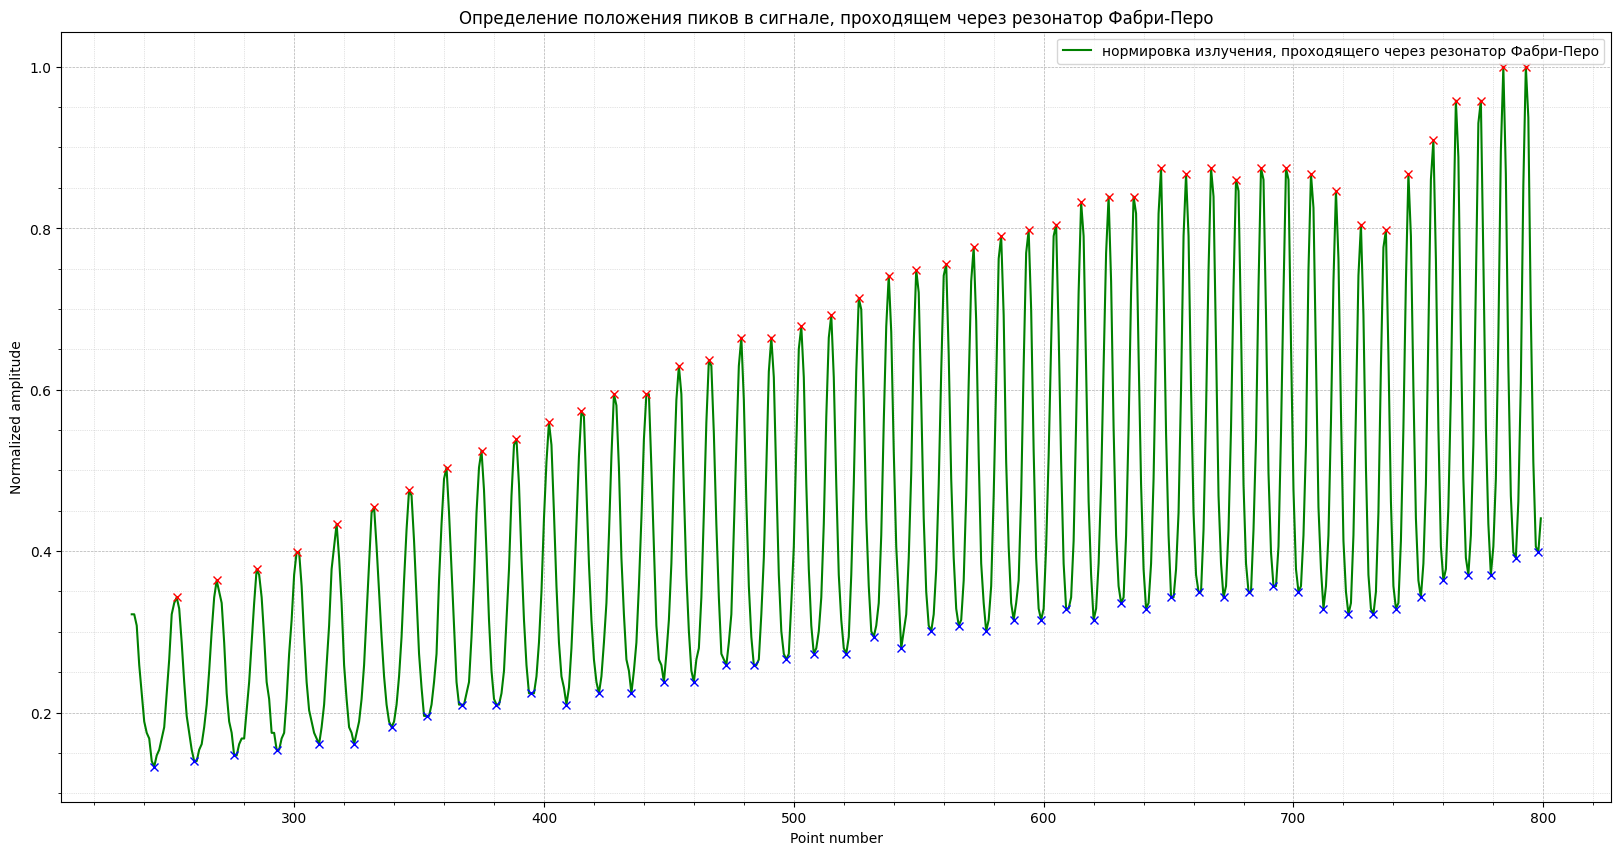

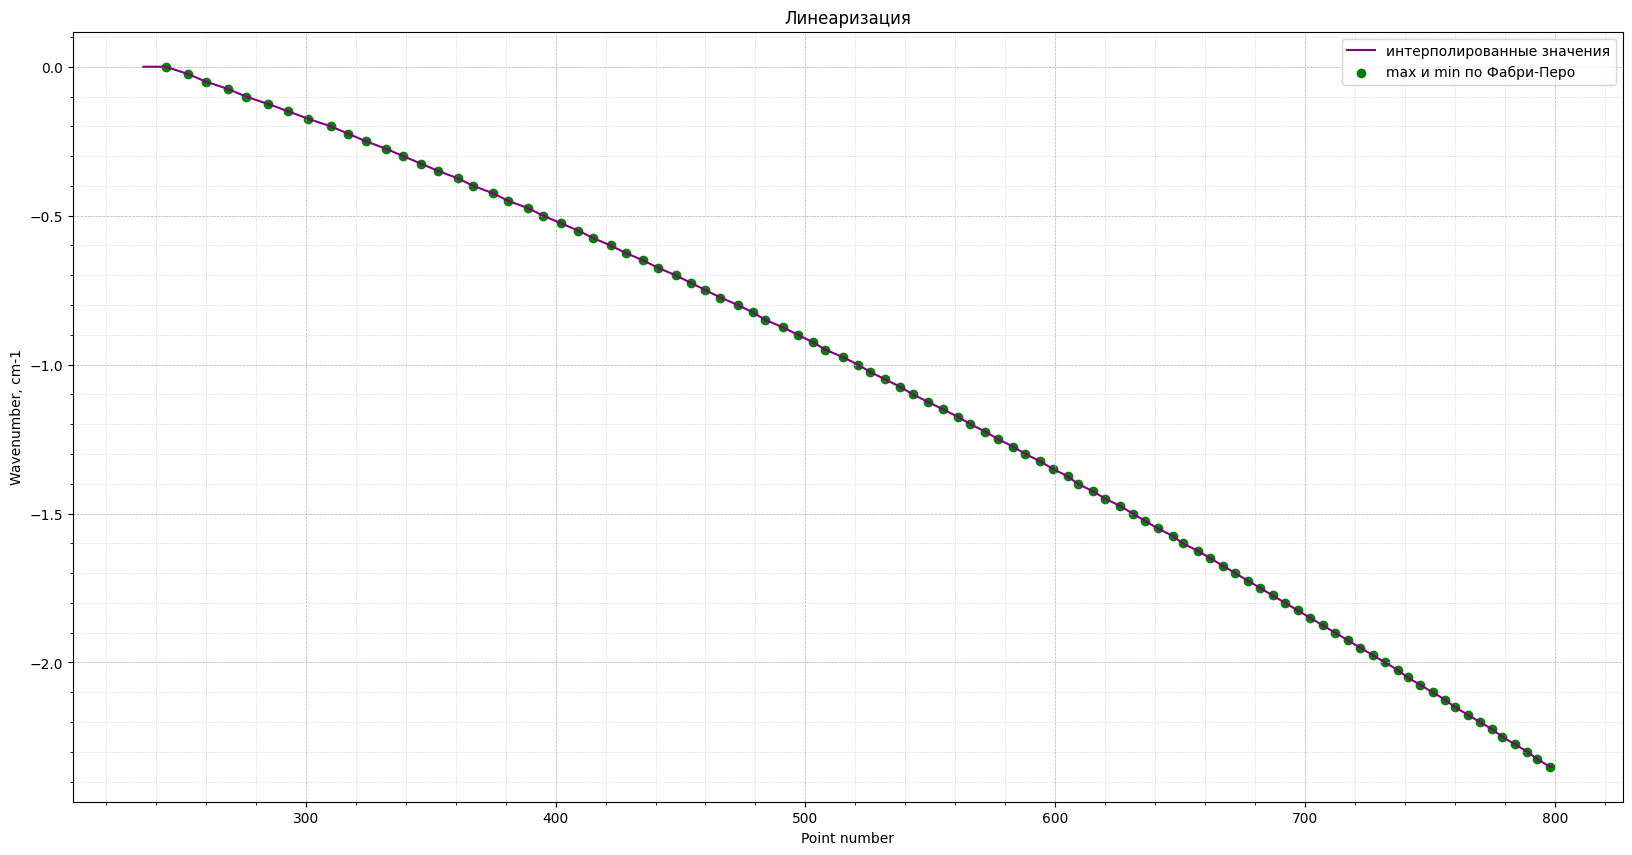

In [62]:
if __name__ == "__main__":
    file_path = '/Users/dandr/Desktop/Спектроскопия/вода/1.txt'
    main(file_path)

4. Переход к абсолютным значениям волновых чисел

In [15]:
max_peaks = [7181.155657, 7182.208851, 7182.94535, 7182.94535, 7183.015675]

In [11]:
wavenum_min = 7180.5
wavenum_max = 7183.5

wn = np.linspace(wavenum_min, wavenum_max, 767)

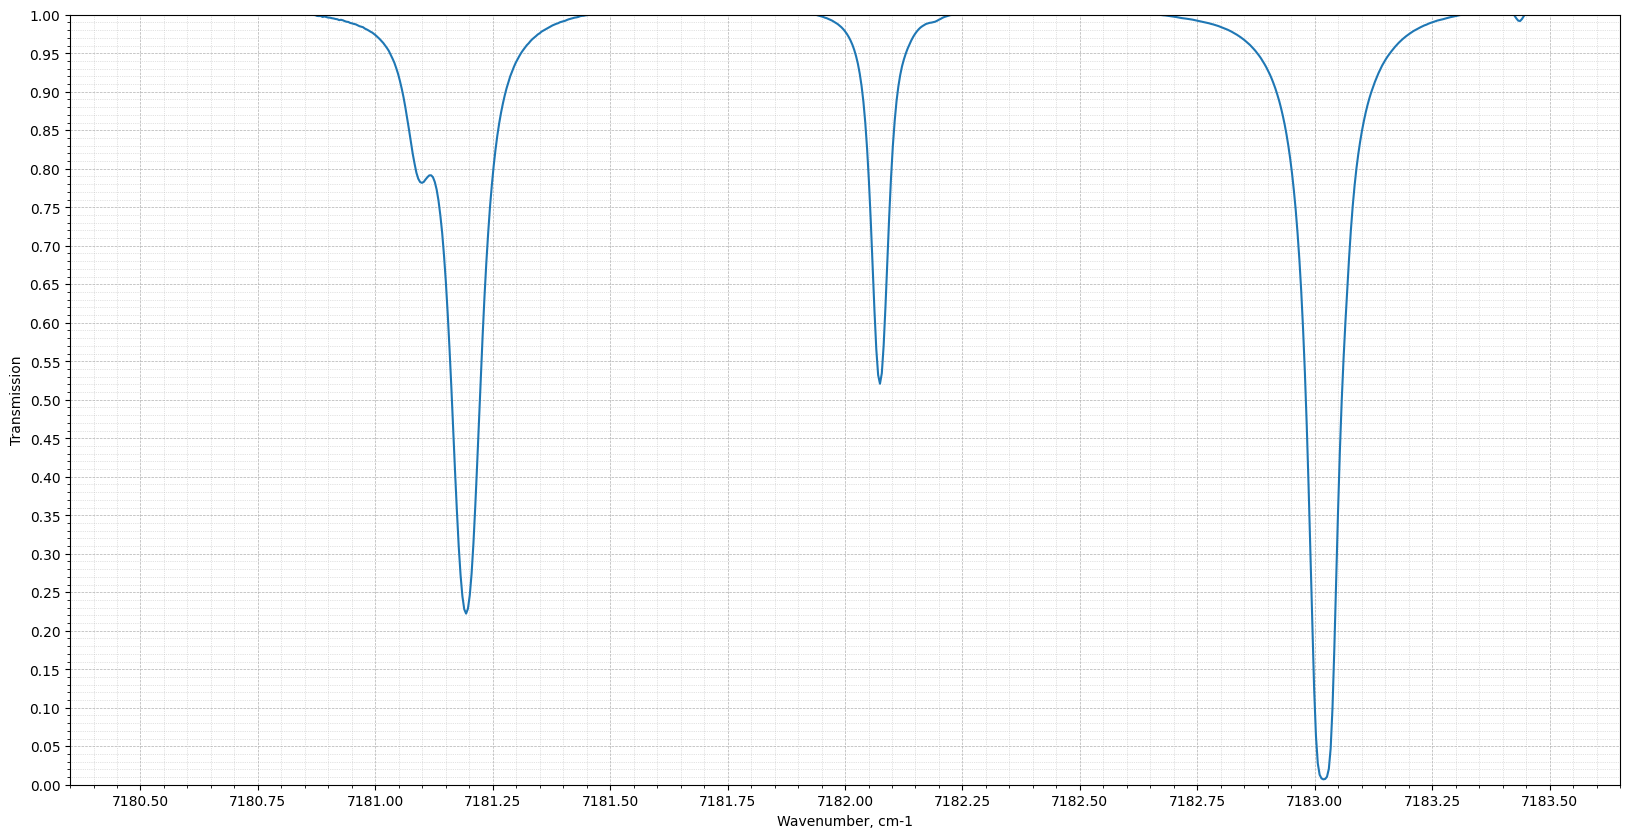

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(wn, y_D)
plt.ylim(0, 1)

plt.xlabel('Wavenumber, cm-1')
plt.ylabel('Transmission')


plt.locator_params(axis='x', nbins=15)
plt.locator_params(axis='y', nbins=20)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.show()